# SVHN Classification Without Neural Nets

NOTE THAT THIS NOTEBOOK WILL TAKE AROUND 8 HOURS TO RUN IN TOTAL DUE TO HYPERPARAMATER SEARCHING

This notebook focuses on classifying the Street View House Numbers dataset using the following techniques to classify street view house numbers: support vector (SVC), random forest, logistic regression, k-nearest neighbors (KNN) ane ensemble of the above. The dataset can be found at http://ufldl.stanford.edu/housenumbers/.

# Preprocessing

The following preprocessing techniques were used: Reshaping the dataset, converting RGB to grayscale, scaling the data, and undersampling the training data to select 2000 data from the whole dataset and have an even distribution among classes.

In [1]:
# import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import io
from PIL import Image
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import datasets
from sklearn.metrics import accuracy_score
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler()
from sklearn.metrics import confusion_matrix
from skimage import color
from skimage.feature import hog
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import h5py

C:\Users\Celin\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


We load in the datasets using loadmat, and preprocess the data.

In [2]:
# path to original very large dataset
tr_set = "C:/Users/Celin/Desktop/CelineFirstJupyter/Street_num Final Project/Format 2/train_32x32.mat"
te_set = "C:/Users/Celin/Desktop/CelineFirstJupyter/Street_num Final Project/Format 2/test_32x32.mat"

In [3]:
# load-in whole data set
data = loadmat(tr_set)
te_data = loadmat(te_set)

X_tr, y_tr = data['X'], data['y']
X_te, y_te = te_data['X'], te_data['y']


In [4]:
# training data details
print ("Training Set Shape Params: <width, height, channels [rgb], # of images>")
print("X Shape: ", X_tr.shape, " y Shape: ", y_tr.shape)

Training Set Shape Params: <width, height, channels [rgb], # of images>
X Shape:  (32, 32, 3, 73257)  y Shape:  (73257, 1)


In [5]:
# transpose data to (# of images, width, height, rgb)
X_tr, y_tr = X_tr.transpose((3,0,1,2)), y_tr[:,0]
X_te, y_te = X_te.transpose((3,0,1,2)), y_te[:,0]

In [6]:
#take 2000 training data and 400 test data from the original dataset as our dataset
X_tr_new=[]
y_tr_new=[]
X_te_new=[]
y_te_new=[]
# y_train_new=list(y_train)
# X_train_new=list(X_train)

for i in range(1,11):
    for a,b in zip(X_tr,y_tr):
        if b == i and y_tr_new.count(i)<200:
            X_tr_new.append(a)
            y_tr_new.append(b)
        else:
            continue
            
for i in range(1,11):
    for a,b in zip(X_te,y_te):
        if b == i and y_te_new.count(i)<80:
            X_te_new.append(a)
            y_te_new.append(b)
        else:
            continue

In [7]:
X_tr=np.array(X_tr_new)
y_tr= np.array(y_tr_new)
X_te=np.array(X_te_new)
y_te= np.array(y_te_new)
print("X Shape: ", X_tr.shape, " y Shape: ", y_tr.shape)

X Shape:  (2000, 32, 32, 3)  y Shape:  (2000,)


In [8]:
# convert RGB to grayscale for feature engineering
def rgb2gray(img_data):
    return np.expand_dims(np.dot(img_data, [0.3, 0.6, 0.1]), axis=3)

X_tr_gr = rgb2gray(X_tr).astype(np.float32) # converts gray training set to float values
X_te_gr = rgb2gray(X_te).astype(np.float32)

X_tr = X_tr_gr # replace original training set
X_te = X_te_gr
print("Training Set", X_tr.shape)
print("Testing Set", X_te.shape)

Training Set (2000, 32, 32, 1)
Training Set (800, 32, 32, 1)


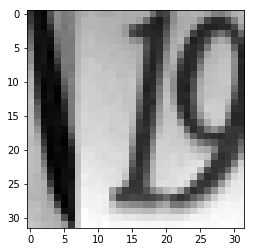

In [9]:
#see can example greyscale image, clarity is still pretty good
digit_img = X_tr[0].reshape((32,32))
plt.imshow(digit_img, cmap='gray')
plt.show()

In [10]:
#more data pre-processing, rreshae the data to the correct form we can use to fit and train
X_tr_resized = X_tr.reshape(2000, 32*32*1)
X_te_resized = X_te.reshape(800, 32*32*1)

In [11]:
#scale our data (normalization) - feature engineering
sc_X = StandardScaler()
X_tr_scaled = sc_X.fit_transform(X_tr_resized)
X_te_scaled = sc_X.transform(X_te_resized)

In [12]:
X_tr_scaled.shape

(2000, 1024)

In [14]:
y_tr.shape

(2000,)

In [15]:
# confirm each trainning class has exactly 200 dataset
from collections import Counter
Counter(y_tr)

Counter({1: 200,
         2: 200,
         3: 200,
         4: 200,
         5: 200,
         6: 200,
         7: 200,
         8: 200,
         9: 200,
         10: 200})

# Fit and Evaluate Various Models

The section below shows various models here, and compare test accuracies. For example, I used random search for random forest and KNN, and grid search for SVC to find the optimal parameters. Because search time is quite significant, some models with a a lot of hyperpramaters possibilities used random search instead of grid search. 

## RandomForest With and Without PCA

In [16]:
rf_noPCA = RandomForestClassifier(n_estimators=10, oob_score=True, random_state=42, min_samples_leaf=1, max_features="auto")

In [17]:
rf_noPCA.fit(X_tr_scaled, y_tr)

C:\Users\Celin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Celin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [18]:
rf_noPCA_prediction = rf_noPCA.predict(X_te_scaled)

In [19]:
# accuracy of no PCA and default random forest 
accuracy_score(y_te,rf_noPCA_prediction)

0.2675

Random forest without PCA and without hyperapramater tuning-> only 27% test accuracy

### Hyperparameter Tuning for Random Forest w/o PCA

Now we search for optimal hyperparameters for the random forest algorithm using 3-fold cross validation.

In [25]:
# random search for optimal parameters of random forest
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50,100,500]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [10,50,200]
# Minimum number of samples required to split a node
min_samples_split = [3,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
random_grid

{'n_estimators': [50, 100, 500],
 'max_features': ['auto'],
 'max_depth': [10, 50, 200],
 'min_samples_split': [3, 5],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [27]:
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_tr_scaled, y_tr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.4min finished
C:\Users\Celin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 500], 'max_features': ['auto'], 'max_depth': [10, 50, 200], 'min_samples_split': [3, 5], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 200,
 'bootstrap': False}

In [29]:
#fit the random forest using the above best paramaters after random search
new_rfc = rf_random.best_estimator_

In [30]:
new_rfc.fit(X_tr_scaled, y_tr)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=200, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)

In [31]:
new_predictRf = new_rfc.predict(X_te_scaled)
accuracy_score(y_te, new_predictRf)

0.4875

The new hyperparameters used after searching achieved a higher test accuracy of 49% in comparison with the previous default hyperparameters with 27%.


### Hyperparameter Tuning for Random Forest with PCA

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(0.95)
X_tr_new = pca.fit_transform(X_tr_scaled)
X_te_new = pca.transform(X_te_scaled)

In [38]:
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_tr_new, y_tr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished
C:\Users\Celin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 500], 'max_features': ['auto'], 'max_depth': [10, 50, 200], 'min_samples_split': [3, 5], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [39]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [41]:
#fit the random forest using the above best paramaters after random search
new_rfc = rf_random.best_estimator_

In [42]:
new_predictRf = new_rfc.predict(X_te_new)
accuracy_score(y_te, new_predictRf)

0.50125

The randomforest's accuracy after PCA preserving 95% variance and hyperparamater tunning increased slightly to 50% from the 49% without PCA. 

In [48]:
confusion_matrix(y_te,new_predictRf)

array([[47,  4,  3,  5,  3,  0,  5,  3,  5,  5],
       [ 2, 41,  7,  2,  7,  0, 10,  4,  5,  2],
       [ 9,  6, 32,  3,  7,  3,  7,  1,  8,  4],
       [ 3,  3,  3, 51,  2,  2,  6,  3,  4,  3],
       [ 2,  6,  7,  3, 34,  7,  3,  4, 10,  4],
       [ 7,  4,  1, 11,  5, 29,  4,  8,  4,  7],
       [ 2,  9,  4,  2,  2,  0, 51,  2,  6,  2],
       [ 2,  7,  3,  0,  3,  4,  6, 31, 16,  8],
       [ 2,  4,  3,  7,  1,  1,  6,  3, 46,  7],
       [ 3,  2,  2,  3,  6,  7,  3,  1, 14, 39]], dtype=int64)

From the confusion matrix:
it seems a lot of 6 are wrongly classified as 4 and 8.
A lot of 0s are wrongly classified as 9.
A lot of 7s are wrong classified as 2
A lot of 5 are wrongly classified as 9

These are all make sense as 6,8,9 have a lot of circles and curvatures. 
7 and 2 could look very similar in hand writting as well.

## KNN classifier with and without PCA

Now we will use a K-nearest neighbors model to predict on the test data, after applying principal component analysis on the training data.

In [58]:
from sklearn.neighbors import KNeighborsClassifier
# train KNN classifier
knn = KNeighborsClassifier()

In [54]:
#KNN without PCA training accuracy score
knn.fit(X_tr_scaled, y_tr)
knn_pred_tr = knn.predict(X_tr_scaled)
accuracy_score(y_tr, knn_pred_tr)

0.528

In [55]:
#KNN default model without PCA testing accuracy score
knn_pred_te = knn.predict(X_te_scaled)
accuracy_score(y_te, knn_pred_te)

0.27375

### KNN no PCA Hyper-paramater tuning

In [60]:
#clearly overfitted when training accuracy is much higher than testing
#need to use random search to find the best KNN model paramater
neighbours=[2,5,7,9,10,12,15,17,18,19,20]
random_grid = {'n_neighbors': neighbours}
print(random_grid)
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
knn_random.fit(X_tr_scaled, y_tr)

{'n_neighbors': [2, 5, 7, 9, 10, 12, 15, 17, 18, 19, 20]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   32.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_neighbors': [2, 5, 7, 9, 10, 12, 15, 17, 18, 19, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [61]:
print(knn_random.best_params_)

{'n_neighbors': 18}


In [67]:
knn_noPCA = knn_random.best_estimator_
knn_pred_tr = knn_noPCA.predict(X_tr_scaled)
accuracy_score(y_tr, knn_pred_tr)

0.411

In [69]:
knn_pred_te = knn_noPCA.predict(X_te_scaled)
accuracy_score(y_te, knn_pred_te)

0.28125

The test accuracy for KNN without PCA increased from 27% to 28% after hyper-paramater searching.

###  KNN with PCA Model  Hyper-paramater Tuning

In [71]:
eighbours=[2,5,7,9,10,12,15,17,18,19,20]
random_grid = {'n_neighbors': neighbours}
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
knn_random.fit(X_tr_new, y_tr)
print(knn_random.best_params_)
knn_PCA = knn_random.best_estimator_
knn_pred_tr = knn_PCA.predict(X_tr_new)
accuracy_score(y_tr, knn_pred_tr)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


{'n_neighbors': 7}


0.5055

In [73]:
# test set prediction
knn_pred_te = knn_PCA.predict(X_te_new)

In [74]:
accuracy_score(y_te, knn_pred_te)

0.295

KNN with PCA after tuning produced a test accuracy of 30& compared with test accuracy of 28% for KNN without PCA after tuning. Once again the model with PCA performed slightly better.Thus, we will use PCA data for the next classifier KNN.

## Support Vector with PCA and Kernel Trick and Grid Search

In [75]:
# try SVM w/ PCA and kernel trick
# grid search for params
svc_grid = SVC(random_state=42)

param_grid = { 
    'gamma': [0.00001, 0.0001, 0.01],
    'C': [1, 10]
}

svc_grid = GridSearchCV(svc_grid, param_grid, cv = 5)

In [76]:
svc_grid.fit(X_tr_new, y_tr)
svc_grid.best_params_

{'C': 10, 'gamma': 0.01}

In [78]:
svc = svc_grid.best_estimator_
print(svc_grid.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [81]:
svc.fit(X_tr_new, y_tr)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
svc_predict_te = svc.predict(X_te_new)
accuracy_score(y_te, svc_predict_te)

0.32

Support vector with PCA and hyer-paramater tuning only achieved 32% test accuracy. Slightly better than KNN but most worse than random forest

## Logistic Regression with PCA

Here, we will train a logistic regression model using parameters {solver = 'lbfgs', and multi_clas = 'ovr'}.

In [83]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver = 'lbfgs', multi_class='ovr').fit(X_tr_new, y_tr)

In [84]:
log_pred = log_reg.predict(X_te_new)

In [85]:
accuracy_score(y_te, log_pred)

0.175

Very low accuracy (17%) when using logistic regression after PCA.

## Ensemble Model

We will now try ensemble learning (stacking) using Support Vector SVC(32% accuracy), KNN(30% accuracy) and Random Forest(50% accuracy) to see if it can increase prediction accuracy on the testing set. We choose to not include logistic regression because it performed very poorly (17% test accuracy).

In [86]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('KNN', knn_PCA),('svc',svc),('RF', new_rfc)], voting='hard')
voting_clf.fit(X_tr_new, y_tr)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')), ('svc', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamm...ators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [87]:
voting_pred = voting_clf.predict(X_te_new)

In [88]:
accuracy_score(y_te, voting_pred)

0.38125

In [90]:
voting_clf = VotingClassifier(estimators=[('svc',svc),('RF', new_rfc)], voting='hard')
voting_clf.fit(X_tr_new, y_tr)
voting_pred = voting_clf.predict(X_te_new)
accuracy_score(y_te, voting_pred)

0.41

Stacking only Support Vector(32% accuracy) and Random Forest (50% accuracy) gives us a slightly slightly better accuracy of 41%, but it's still worse than using random forest alone.

In [91]:
confusion_matrix(y_te, voting_pred)

array([[64,  6,  3,  3,  1,  0,  1,  0,  2,  0],
       [15, 46,  4,  2,  6,  0,  4,  1,  1,  1],
       [27,  9, 24,  4,  4,  3,  5,  0,  4,  0],
       [21,  6,  4, 43,  2,  1,  2,  1,  0,  0],
       [16,  8,  6,  6, 31,  5,  0,  4,  4,  0],
       [26,  2,  0, 12,  6, 24,  0,  6,  3,  1],
       [29, 17,  5,  3,  4,  0, 20,  0,  2,  0],
       [12,  8,  3,  3, 10, 10,  1, 26,  5,  2],
       [15,  5,  1, 10,  3,  3,  7,  7, 27,  2],
       [21,  5,  3,  5,  3,  9,  1,  2,  8, 23]], dtype=int64)

From the confusion matrix, we can see:
A lot of different digits were wrongly classified as 1s
A lot of 7 were misclassified as 2s, 5s and 6s (this happened in random forest as well)
A lot of 6 were misclassified as 4s (this happened in random forest as well)

## Conclusion for Models with 2000 Datapoints

Out of the tested models: Random Forest, SVC , Logistics Regression, KNN, and a stacked ensemble of the models, it appears that Random Forest with PCA attained the highest test accuracy of ~50%, followed by SVC with ~32%, and the stacked ensemble of these two model achieved ~41%. 


# Best Model Trained with Entire Original Dataset of 73257 samples VS 2000 samples 

The part below is beyond the scope of the project, but I'm a bit curious how random forest would perform if trained with the entire dataset 73257 samples instead of 2000 samples. Due to the very long run-time on such large dataset, I will only try this with the best model, not the rest of the models that performed more poorly to see how much better random forest would perform using 73257 training data on the same test set.

In [96]:
# load-in whole data set and pre-process the exact same way
data = loadmat(tr_set)
X_tr, y_tr = data['X'], data['y']
X_tr, y_tr = X_tr.transpose((3,0,1,2)), y_tr[:,0]
X_tr=np.array(X_tr)
y_tr= np.array(y_tr)
# convert RGB to grayscale for feature engineering
def rgb2gray(img_data):
    return np.expand_dims(np.dot(img_data, [0.3, 0.6, 0.1]), axis=3)

X_tr_gr = rgb2gray(X_tr).astype(np.float32) # converts gray training set to float values
X_tr = X_tr_gr # replace original training set
print("Training Set", X_tr.shape)
X_tr_resized = X_tr.reshape(73257, 32*32*1)
sc_X = StandardScaler()
X_tr= sc_X.fit_transform(X_tr_resized)

Training Set (73257, 32, 32, 1)


In [97]:
rf_newPCA = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)
rf_newPCA.fit(X_tr, y_tr)
new_predictRf = rf_newPCA.predict(X_te_scaled)
accuracy_score(y_te, new_predictRf)

0.67625

Model using the entire original training dataset of 73257 data performed significantly better with test accuracy of 68%, compared with the same model trained using 2000 training data achieveing test accuracy of 50%. However, 68% is still not a satisfactory performance, thus Convolutional neural network model is utilized instead, see notebooks 2 and 3. 